Second trial with input as nii files. 

In [1]:
import nibabel as nib
import numpy as np
nifti = nib.load("/home/ecbm4040/vibes_auto_pipe/t2bet.nii")
# retrieve nifti data
data = nifti.get_fdata()
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255.0
data = data.astype(np.uint8)  # Convert to 8-bit unsigned integers

In [2]:
print(data.shape) # (96, 96, 48) # there are 48 slices
import cv2
import os
output_dir = "/home/smooi/vibes_auto_pipe/output"

# Iterate through the slices 
for i in range(data.shape[2]): #iter thru 1 to 48 
    slice_ = data[:, :, i] # 2D slices
    resized_slice = cv2.resize(slice_, (160, 160), interpolation=cv2.INTER_AREA)
    # Scale to Full Grayscale Range [0, 255]
    img_max_range = resized_slice.max()
    output_img = (resized_slice / img_max_range) * 255
    output_path = os.path.join(output_dir, f"slice_{i:03d}.png") 
    cv2.imwrite(output_path, output_img)
    print(f"Saved: {output_path}")
    


(96, 96, 48)
Saved: /home/smooi/vibes_auto_pipe/output/slice_000.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_001.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_002.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_003.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_004.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_005.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_006.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_007.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_008.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_009.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_010.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_011.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_012.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_013.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_014.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_015.png
Saved: /home/smooi/vibes_auto_pipe/output/slice_016.png
Saved: /home/smooi/vibes_auto_pipe/

In [3]:
# load a png file and explore its min and max
picture = "/home/ecbm4040/vibes_auto_pipe/output/slice_001.png"

# chatgpt's code to examine a png file
image = cv2.imread(picture, cv2.IMREAD_UNCHANGED)

# Display basic information
print(f"Image Shape: {image.shape}")  # Dimensions: (height, width, channels)
print(f"Data Type: {image.dtype}")    # Pixel data type (e.g., uint8)
print(f"Min Pixel Value: {image.min()}")  # Minimum pixel intensity
print(f"Max Pixel Value: {image.max()}")  # Maximum pixel intensity

# Currently, there's no channel info
# It is also observed that the pixel range is not Scale to Full Grayscale Range [0, 255]

Image Shape: (160, 160)
Data Type: uint8
Min Pixel Value: 0
Max Pixel Value: 255


In [4]:
import tensorflow as tf

mydir = "/home/ecbm4040/vibes_auto_pipe/output"

def prepare_image_for_tf(img):
    brain_img = tf.io.read_file(img)
    brain_img = tf.io.decode_png(brain_img, channels=1) # brain img channels=1 greyscale
    brain_img = tf.image.resize(brain_img, [160, 160]) # Necessary since inputs may be varying in size from different trials
    brain_img = tf.cast(brain_img, tf.float32)  
    
    return brain_img

# Process all images in the directory
def process_all_images(directory):
    image_tensors = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):  # Process only PNG files
            img_path = os.path.join(directory, filename)
            processed_img = prepare_image_for_tf(img_path)
            image_tensors.append(processed_img)
    return tf.stack(image_tensors)  # Stack into a batch tensor

# Process images in the directory
image_batch = process_all_images(mydir)
print(f"Processed Image Batch Shape: {image_batch.shape}") # Processed Image Batch Shape: (48, 160, 160, 1)  48 refers to the batch size 


Processed Image Batch Shape: (48, 160, 160, 1)


In [ ]:
# # let's reexamine the shape and intensity of the images
# for brain_img in image_batch:
    
#     print("Brain Image range: Min =", tf.reduce_min(brain_img).numpy(), 
#           "Max =", tf.reduce_max(brain_img).numpy())
    
# yes, its min = 0 and max = 255 now. 

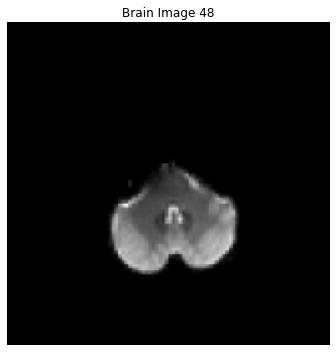

In [5]:
# show brain figures that we want to visualize
# View 10 random brain image and mask from training data:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))

for image in image_batch:  # Let's examine five pairs
    # i: represent index var for each iteration
    # Show brain image
    squeezed_brain_img = tf.squeeze(image, axis=-1)  # Remove the channel dimension (which indicates greyscale)
    plt.imshow(squeezed_brain_img, cmap="gray")
    plt.title(f"Brain Image {i + 1}")
    plt.axis("off")
    plt.tight_layout() 
    # plt.show() 



In [5]:
from tensorflow.keras.models import load_model
from loss_funcs import loss_function

# create the instance
my_loss_func = loss_function()

dice_coefficient = my_loss_func.dice_coefficient
dice_loss = my_loss_func.dice_loss


# Load the train model:
saved_model_path = "/home/ecbm4040/vibes_auto_pipe/unet_w_aug.h5"
model = load_model(saved_model_path, custom_objects={"dice_loss": dice_loss, "dice_coefficient": dice_coefficient})
print("Model Loaded Successfully!")


Your loss function class initiate successfully!
Model Loaded Successfully!


In [6]:
# Make the predictions 
predictions = model.predict(image_batch)

In [7]:
binary_predictions = (predictions > 0.5).astype(int)
predicted_mask = binary_predictions.squeeze()

In [9]:
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('trial1.pdf') as pdf:
#     for image in image_batch:  # Iterate over individual images
#         # Expand dimensions to add batch size of 1 (for single-image prediction)
#         image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, 160, 160, 1)

#         # Predict the mask
#         predicted_mask = model.predict(image_expanded)  # Output shape: (1, 160, 160, 1)
#         predicted_mask = (predicted_mask > 0.5).astype(int).squeeze()  # Remove batch dimension

#         # Plot input image and predicted mask
#         plt.figure(figsize=(10, 5))

#         # Input image
#         plt.subplot(1, 2, 1)
#         plt.title("Input Image")
#         plt.imshow(image[:, :, 0], cmap='gray')  # Original shape: (160, 160, 1)
#         plt.axis('off')

#         # Predicted mask
#         plt.subplot(1, 2, 2)
#         plt.title("Predicted Mask")
#         plt.imshow(predicted_mask, cmap='gray')  # Predicted mask shape: (160, 160)
#         plt.axis('off')

#         # Save the figure to the PDF
#         print("Saving figure...")
#         pdf.savefig()
#         plt.close()


Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...
Saving figure...


In [21]:
print(predicted_mask.shape)
predicted_mask_reordered = np.transpose(predicted_mask, (1, 2, 0))
print(predicted_mask_reordered.shape)

# In order to transfer this back to the nii file,
# we have to follow the original nifti file format,
# which should have the slice number at the end (e.g. (160, 160, 48))

# Create an nifti object
affine = nifti.affine
new_nifti = nib.Nifti1Image(predicted_mask_reordered, affine)

# change the format 
nib.save(new_nifti, "predicted_masks1.nii")
print("NIfTI file saved as 'predicted_masks1.nii'")


(48, 160, 160)
(160, 160, 48)
NIfTI file saved as 'predicted_masks.nii'


In [22]:
# verify the aboved saved file
saved_nifti = nib.load("/home/ecbm4040/vibes_auto_pipe/predicted_masks1.nii")
loaded_data = saved_nifti.get_fdata()

print(f"Loaded NIfTI shape: {loaded_data.shape}")  # Should match your mask shape


Loaded NIfTI shape: (160, 160, 48)
